In [2]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np 
import json 


## segmentation with detectron2 

In [3]:
#!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15777, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15777 (delta 7), reused 21 (delta 4), pack-reused 15743 (from 1)
Receiving objects: 100% (15777/15777), 6.35 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (11501/11501), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.9 MB/s eta 0:00

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
torch:  2.4 ; cuda:  2.4.0
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## train on custom dataset 

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/input/log-dt/coco_format/coco_format/dataset.json", "/kaggle/input/log-dt/coco_format/coco_format")
#register_coco_instances("my_dataset_val", {}, "/kaggle/input/building-extraction-generalization-2024/val/val.json", "/kaggle/input/building-extraction-generalization-2024/val")

train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

#val_metadata = MetadataCatalog.get("my_dataset_val")
#val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[09/18 05:06:03 d2.data.datasets.coco]: Loaded 590 images in COCO format from /kaggle/input/log-dt/coco_format/coco_format/dataset.json


## train 

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[09/18 05:06:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 87.5MB/s]                            


In [9]:
trainer.train() #Start the training process

[09/18 05:06:15 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/18 05:06:34 d2.utils.events]:  eta: 0:19:01  iter: 19  total_loss: 1.916  loss_cls: 0.5909  loss_box_reg: 0.5775  loss_mask: 0.6915  loss_rpn_cls: 0.03719  loss_rpn_loc: 0.02981    time: 0.7728  last_time: 0.7675  data_time: 0.0311  last_data_time: 0.0114   lr: 4.9953e-06  max_mem: 4782M
[09/18 05:07:02 d2.utils.events]:  eta: 0:18:53  iter: 39  total_loss: 1.895  loss_cls: 0.5559  loss_box_reg: 0.6195  loss_mask: 0.6685  loss_rpn_cls: 0.03033  loss_rpn_loc: 0.02935    time: 0.7791  last_time: 0.8068  data_time: 0.0149  last_data_time: 0.0188   lr: 9.9902e-06  max_mem: 4873M
[09/18 05:07:18 d2.utils.events]:  eta: 0:18:49  iter: 59  total_loss: 1.83  loss_cls: 0.5019  loss_box_reg: 0.6509  loss_mask: 0.6217  loss_rpn_cls: 0.02715  loss_rpn_loc: 0.02655    time: 0.7837  last_time: 0.7895  data_time: 0.0149  last_data_time: 0.0107   lr: 1.4985e-05  max_mem: 4903M
[09/18 05:07:34 d2.utils.events]:  eta: 0:18:36  iter: 79  total_loss: 1.681  loss_cls: 0.4328  loss_box_reg: 0.6346  loss

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [11]:

import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/kaggle/working/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

## evaluation 

In [12]:

# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[09/18 05:32:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

## load the model in case of previously trained

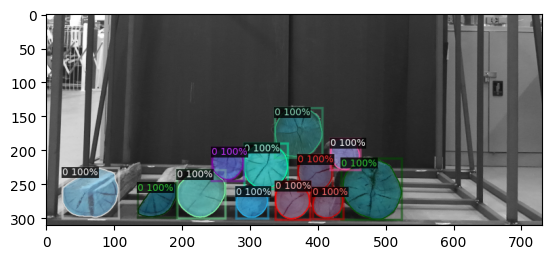

In [23]:
from detectron2.utils.visualizer import ColorMode

for d in os.listdir('/kaggle/input/log-dt/test_data/test_data'):    #select number of images for display
    if d.endswith('.png'):
        im = cv2.imread('/kaggle/input/log-dt/test_data/test_data/'+d)
 
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(out.get_image()[:, :, ::-1])
        # Save the figure to a file
        output_path = '/kaggle/working/'+'seg'+d  # Define the output path
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Save the figure
plt.show()

##counting the object 

In [33]:
im = cv2.imread('/kaggle/input/log-dt/test_data/test_data/00300-ZED-Left-1622128958.png')
outputs = predictor(im)
outscore=outputs["instances"].to("cpu").scores.numpy()
num_of_object=len(outscore[outscore > 0.5])
print(f'the number of object {num_of_object}')

the number of object 12
